# California Housing Price Prediction

**Author:** Venkatesh Tantravahi

**Dataset:** [link](https://inria.github.io/scikit-learn-mooc/python_scripts/datasets_california_housing.html)

## 1. Executive Summary & Business Problem

**Objective:** Develop a machine learning model to predict median house values in California districts based on aggregate data (e.g., income, house age, rooms).

**Usage:** This model will serve as the backend for the "Price Estimator" feature in our user-facing real estate application. Metric for Success: We will optimize for RMSE (Root Mean Squared Error) to penalize large errors significantly, as accurate pricing is critical for user trust.

## 2. Environment Setup

In [1]:
!pip install pyngrok

In [2]:
!pip install mlflow plotly-express

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.0/40.0 kB 1.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.9/8.9 MB 58.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 37.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 27.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 147.8/147.8 kB 10.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.9/114.9 kB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.0/85.0 kB 3.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.9/76.9 kB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 753.9/753.9 kB 20.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.3/207.3 kB 9.7 MB/s eta 0:00:00


In [3]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import plotly_express as px
import joblib
import mlflow
import urllib
import mlflow.sklearn
from mlflow.models import infer_signature

#Scikit-Learn
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error, r2_score

# --- MLFLOW CONFIGURATION ---
# Set the tracking URI to a local folder (or a remote server URL in production)
mlflow.set_tracking_uri("file:./mlruns")


# Define the Experiment Name
# This creates a "folder" in the MLflow UI to hold all runs for this specific project
experiment_name = "California_Housing_Production_V1"
mlflow.set_experiment(experiment_name)

# Enable Autologging
# This automatically logs params (n_estimators), metrics (MSE), and the model file itself.
mlflow.sklearn.autolog(
    log_input_examples=True,
    log_model_signatures=True,
    log_models=True
)

# Plot Configuration
%matplotlib inline
plt.style.use('ggplot')
RANDOM_STATE = 42

print(f"MLflow Tracking URI: {mlflow.get_tracking_uri()}")
print(f"Experiment Name: {experiment_name}")

/usr/local/lib/python3.12/dist-packages/mlflow/tracking/_tracking_service/utils.py:177: FutureWarning: The filesystem tracking backend (e.g., './mlruns') will be deprecated in February 2026. Consider transitioning to a database backend (e.g., 'sqlite:///mlflow.db') to take advantage of the latest MLflow features. See https://github.com/mlflow/mlflow/issues/18534 for more details and migration guidance.
  return FileStore(store_uri, store_uri)
2025/12/07 16:39:43 INFO mlflow.tracking.fluent: Experiment with name 'California_Housing_Production_V1' does not exist. Creating a new experiment.


MLflow Tracking URI: file:./mlruns
Experiment Name: California_Housing_Production_V1


## 3. Data Ingestion

We are using the standard California Housing dataset. In a real scenario, this would likely be a SQL query or a call to an S3 bucket.


**Data Dictionary:**

1. `MedInc:` Median Income in block group

2. `HouseAge:` Median House Age in block group

3. `AveRooms:` Average number of rooms per household

4. `AveBedrms:` Average number of bedrooms per household

5. `Population:` Block group population

6. `AveOccup:` Average number of household members

7. `Latitude/Longitude:` Block group coordinates

8. `Target:` MedHouseVal (Median house value in $100k)


In [4]:
# Load Data
data = fetch_california_housing(as_frame=True)
df = data.frame

# Quick inspection
print(f"Dataset Shape: {df.shape}")
df.head()

Dataset Shape: (20640, 9)


,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,MedHouseVal
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23,4.526
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22,3.585
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24,3.521
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25,3.413
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25,3.422


## 4. Exploratory Data Analysis (EDA)

Before modeling, we must understand the data geometry and check for anomalies.

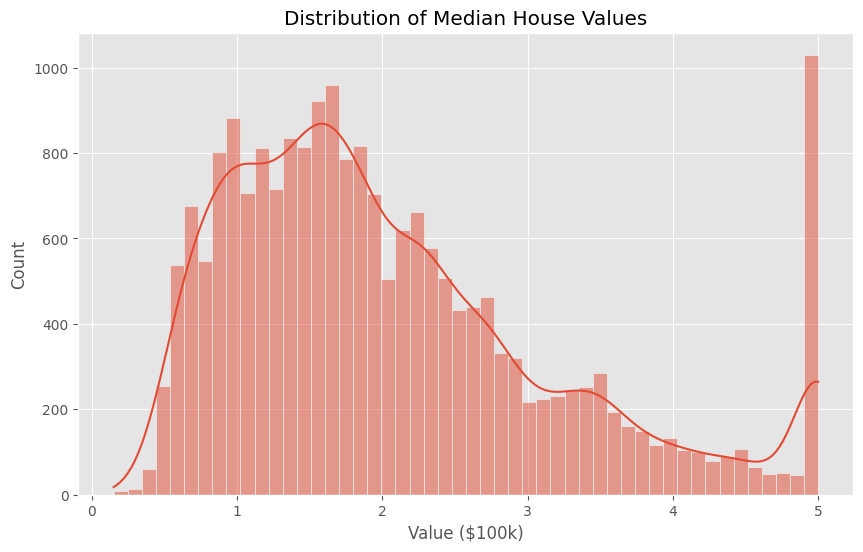

In [5]:
plt.figure(figsize=(10, 6))
sns.histplot(df['MedHouseVal'], kde=True, bins=50)
plt.title('Distribution of Median House Values')
plt.xlabel('Value ($100k)')
plt.show()

`Observation:` The target variable shows a cap at 5.0 ($500,000). This "**ceiling effect**" is a known issue in this dataset and may confuse the model. We should consider filtering this or noting it as a model limitation.

In [6]:
fig = px.scatter_mapbox(
    df,
    lat="Latitude",
    lon="Longitude",
    color="MedHouseVal",
    size="Population",
    color_continuous_scale=px.colors.sequential.Viridis,
    size_max=15,
    zoom=5,
    mapbox_style="open-street-map",
    hover_name="MedHouseVal",
    hover_data=['MedInc', 'HouseAge', 'Population', 'MedHouseVal'],
    title='California Housing Prices by Location'
)

fig.show()

### Summary of Insights from Interactive Geo Plot

The interactive geographical scatter plot provides several key insights into the California housing data:

1.  **Geographical Distribution of Prices**: Higher median house values (indicated by brighter colors on the Viridis scale) are predominantly concentrated along the coastlines, especially in the major metropolitan areas of Southern California (e.g., Los Angeles, San Diego) and the Bay Area (e.g., San Francisco, San Jose). Inland areas generally show lower median house values.

2.  **Population Density and Prices**: The size of the points represents population density. There appears to be a strong correlation between higher population density and higher housing prices. Large, brightly colored points are clustered in urban centers, reinforcing the observation that desirable, densely populated regions command higher housing values.

3.  **Regional Differences**: Specific high-value clusters are visible, such as around Los Angeles, San Francisco Bay, and parts of the Central Coast. This visualization allows for quick identification of regional housing market variations.

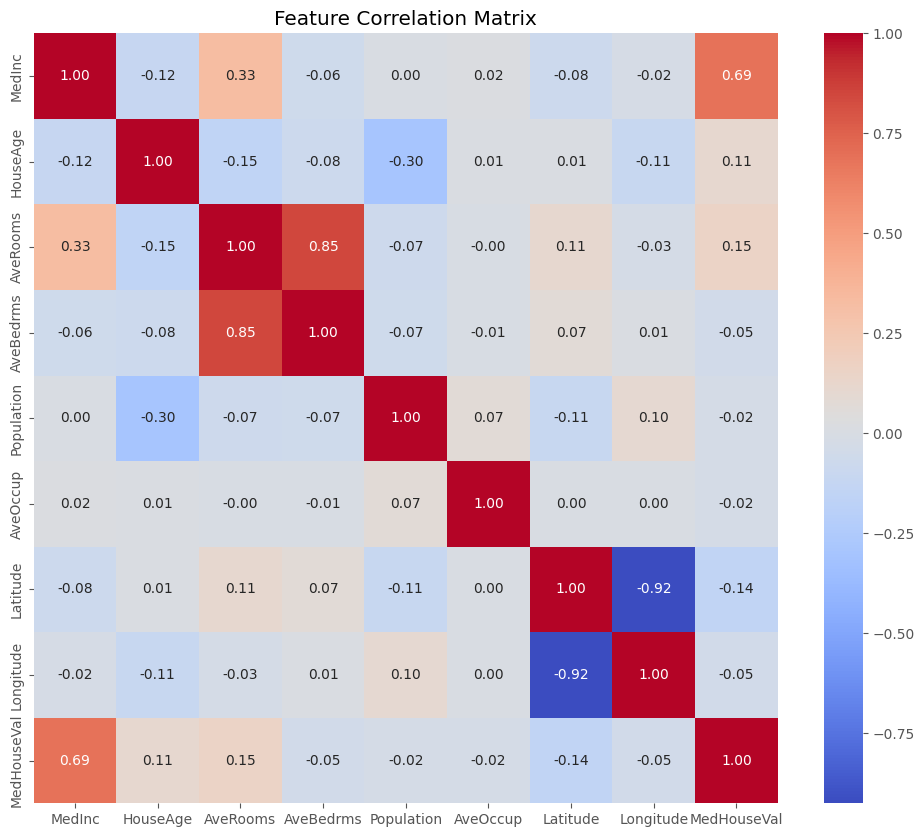

In [7]:
plt.figure(figsize=(12, 10))
sns.heatmap(df.corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Feature Correlation Matrix")
plt.show()

**Some Observations Include**

- `Median Income (MedInc)` shows the strongest positive correlation (0.68) with `Median House Value (MedHouseVal)`, indicating it's a key predictor.
- `Average Rooms (AveRooms)` has a moderate positive correlation (0.15) with MedHouseVal.
- `Latitude` has a notable negative correlation (-0.14) with MedHouseVal, suggesting house values decrease as you move North in California.
- High correlation between `AveRooms` and `AveBedrms` (0.84) indicates potential multicollinearity.

## 5. Feature Engineering & Splitting
To ensure the code is production-ready, we avoid manual manipulation of the raw data frames where possible and instead rely on Pipelines.

In [8]:
# Capping Average Occupancy to remove extreme outliers for training stability
df = df[df['AveOccup'] < 50]

In [9]:
X = df.drop(["MedHouseVal", "Latitude", "Longitude"], axis=1)
y = df["MedHouseVal"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=RANDOM_STATE
)

In [10]:
X_train.head()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup
4323,2.5982,42.0,3.652893,1.062810,1228.0,2.029752
2271,3.5542,43.0,6.268421,1.134211,874.0,2.300000
8272,2.9384,38.0,4.301862,1.022606,1284.0,1.707447
18229,3.5179,22.0,3.168085,0.927660,662.0,1.408511
9384,6.0238,23.0,4.910714,1.199405,541.0,1.610119


In [11]:
X_test.head()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup
18604,5.2080,46.0,6.094801,1.235474,850.0,2.599388
20089,2.9457,21.0,10.845815,2.127753,1175.0,2.588106
18576,2.0775,44.0,3.053156,1.026578,1321.0,4.388704
2748,4.3021,15.0,5.101083,1.007220,803.0,2.898917
9843,3.0625,45.0,5.242424,0.960373,944.0,2.200466


In [12]:
y_train.shape

(16506,)

## 6. Model Development
Instead of training models in isolation, we will use **MLflow** to track multiple candidate models. We will treat the Linear Regression as our "Baseline" and the Random Forest as our "Challenger."

Our goal is to run both, track their performance, and automatically identify the best model for deployment.

In [13]:
# Candidate1: Ridge (linear base model)
ridge_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('model', Ridge(alpha=1.0))
])

# candidate2: Random Forest (challenger)
rf_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('model', RandomForestRegressor(n_estimators=100, max_depth=20, random_state=42))
])


# Dictionary to iterate through
model_candidates = {
    "Baseline_Ridge": ridge_pipeline,
    "Challenger_RandomForest": rf_pipeline
}

In [14]:
from pyngrok import ngrok
from google.colab import userdata
NGROK_AUTH_TOKEN = userdata.get('ngrok_secret')

ngrok.kill()
ngrok.set_auth_token(NGROK_AUTH_TOKEN)

# get_ipython().system_raw("mlflow ui --port 5000 &")

public_url = ngrok.connect(addr="5000", proto="http", bind_tls=True).public_url

print(f"MLflow UI is live at: {public_url}")

MLflow UI is live at: https://beckie-untremolant-hilary.ngrok-free.dev


In [15]:
"""
We iterate through our candidates. For each model, we:
1. Start an MLflow context.
2. Train the pipeline.
3. Calculate Test RMSE (Critical: Autolog captures training loss, we strictly need Test loss).
4. Log the model with a signature (Input/Output Schema).

"""

for run_name, pipeline in model_candidates.items():

    with mlflow.start_run(run_name=run_name) as run:
      print(f"Training: {run_name} | Run ID: {run.info.run_id}")

      # 1. Train (Autologging captures params here)
      pipeline.fit(X_train, y_train)

      # 2. Predict on Hold-out Test Set
      y_pred = pipeline.predict(X_test)

      # 3. Calculate Metrics
      test_rmse = np.sqrt(mean_squared_error(y_test, y_pred))
      test_r2 = r2_score(y_test, y_pred)

      # 4. Log Metrics Manually (to ensure 'test_rmse' is explicitly tracked)
      mlflow.log_metric("test_rmse", test_rmse)
      mlflow.log_metric("test_r2", test_r2)

      # 5. Signature & Logging
      # Define what the input looks like so the deployment server knows what to expect
      signature = infer_signature(X_train, y_pred)


      # We enforce logging the pipeline (Scaler + Model)
      mlflow.sklearn.log_model(
          sk_model=pipeline,
          name="model_pipeline",
          signature=signature,
          input_example=X_train.head(5)
      )

      print(f"  --> Score: RMSE={test_rmse:.4f}, R2={test_r2:.4f}\n")


Training: Baseline_Ridge | Run ID: dde4f58adbeb40c2b5564c7bb80954ba
  --> Score: RMSE=0.7732, R2=0.5516

Training: Challenger_RandomForest | Run ID: e272e2c8ad1742b389781d767d1dc57d
  --> Score: RMSE=0.6497, R2=0.6834



In [16]:
# Search for the best run in this experiment
best_run = mlflow.search_runs(
    experiment_names=[experiment_name],
    order_by=["metrics.test_rmse ASC"], # Ascending because lower RMSE is better
    max_results=1
).iloc[0]

best_run_id = best_run.run_id
best_model_name = best_run['tags.mlflow.runName']
best_rmse = best_run['metrics.test_rmse']

In [17]:
print(f"BEST MODEL: {best_model_name}")
print(f"ID: {best_run_id}")
print(f"RMSE: {best_rmse:.4f}")

BEST MODEL: Challenger_RandomForest
ID: e272e2c8ad1742b389781d767d1dc57d
RMSE: 0.6497


## 7. Hyperparameter Tuning (Optimization)
We have successfully identified that the **Random Forest** approach works best for this dataset. However, the current parameters (e.g., `n_estimators=100`) were chosen arbitrarily.

To build a "Perfect" model, we will use `GridSearchCV` to exhaustively search for the optimal combination of hyperparameters. We will focus on:
* `n_estimators`: The number of trees in the forest. More is usually better but slower.
* `max_depth`: The maximum depth of the tree. Limits overfitting.
* `min_samples_split`: The minimum number of samples required to split an internal node.

*Note: We execute this search within a new MLflow run to automatically log the best parameters found.*

In [18]:
from sklearn.model_selection import GridSearchCV

# 1. Define the Parameter Grid
# We tune the Random Forest pipeline since it was our best candidate.
# Note: We use 'model__' prefix because the RF is inside a Pipeline step named 'model'
param_grid = {
    'model__n_estimators': [100, 200, 300],
    'model__max_depth': [10, 20, None],
    'model__min_samples_split': [2, 5]
}

# 2. Configure the Grid Search
# cv=3 means we test each combination 3 times (3-fold Cross Validation)
# scoring='neg_mean_squared_error' optimizes for the lowest error
grid_search = GridSearchCV(
    rf_pipeline,
    param_grid,
    cv=3,
    scoring='neg_mean_squared_error',
    n_jobs=-1,
    verbose=1
)

# 3. Run Tuning inside MLflow
print("Starting Hyperparameter Tuning...")
with mlflow.start_run(run_name="Hyperparameter_Tuning_RF") as run:

    # Fit the grid search
    # MLflow autolog (already enabled) will log the best parameters and metrics automatically
    grid_search.fit(X_train, y_train)

    # Capture the Tuned Run ID
    tuned_run_id = run.info.run_id

    # Get the best model object directly
    tuned_model = grid_search.best_estimator_

    # Get the best score (convert from negative MSE to RMSE)
    tuned_cv_score = np.sqrt(-grid_search.best_score_)

    print(f"\nBest Parameters Found: {grid_search.best_params_}")
    print(f"Best CV RMSE: {tuned_cv_score:.4f}")

Starting Hyperparameter Tuning...
Fitting 3 folds for each of 18 candidates, totalling 54 fits


2025/12/07 16:54:20 INFO mlflow.sklearn.utils: Logging the 5 best runs, 13 runs will be omitted.



Best Parameters Found: {'model__max_depth': 10, 'model__min_samples_split': 5, 'model__n_estimators': 300}
Best CV RMSE: 0.6434


In [19]:
# 4. Evaluate Tuned Model on the Hold-out Test Set
# (CV score is good, but Test Set is the real truth)
y_pred_tuned = tuned_model.predict(X_test)
tuned_test_rmse = np.sqrt(mean_squared_error(y_test, y_pred_tuned))

print(f"Tuned Model Test RMSE:   {tuned_test_rmse:.4f}")
print(f"Original Best Run RMSE:  {best_rmse:.4f}")

# 5. Final Selection Logic
if tuned_test_rmse < best_rmse:
    print("\n Tuning improved performance! Promoting Tuned Model.")
    production_model = tuned_model
    final_run_id = tuned_run_id
else:
    print("\n Tuning did not beat the baseline. Reverting to original Best Run.")
    # Load the original model from MLflow
    production_model = mlflow.sklearn.load_model(f"runs:/{best_run_id}/model_pipeline")
    final_run_id = best_run_id

print(f"Final Production Model Run ID: {final_run_id}")

Tuned Model Test RMSE:   0.6461
Original Best Run RMSE:  0.6497

 Tuning improved performance! Promoting Tuned Model.
Final Production Model Run ID: 985aee6a098442fbb833963390e7a818


## 8. Final Test & Serialization

We load the best model specifically using its Run ID to ensure we are using the exact artifact that produced the metric.

In [21]:
# Final sanity check using the winner
sample_input = X_test.iloc[[0]]
prediction = production_model.predict(sample_input)

print(f"Final Prediction for input {sample_input.index.values}: ${prediction[0]:.2f}k")

# Optional: Save locally if needed
joblib.dump(production_model, 'california_housing_final_model.joblib')

Final Prediction for input [18604]: $3.14k


['california_housing_final_model.joblib']